**Dans cette section, on fait l'analyse descriptive entre les annéees 2007 et 2020 dans la petite courounne de Paris pour les variables suivantes:**
* **Brevet**
* **Bac**
* **Catégorie Socioprofessionnelle**

# 0 : Traitement des données et libraries

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px
%matplotlib inline
import sys
import warnings
from  matplotlib.colors import LinearSegmentedColormap
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [7]:
# Base de données pour l'analyse de Brevet
#SOURCE:https://data.education.gouv.fr/explore/dataset/fr-en-dnb-par-etablissement/information/?disjunctive.session&disjunctive.numero_d_etablissement&disjunctive.denomination_principale&disjunctive.secteur_d_enseignement&disjunctive.commune_et_arrondissement&disjunctive.commune_et_arrondissement_lib_l&disjunctive.departement&disjunctive.departement_libelle&disjunctive.academie&disjunctive.academie_libelle&disjunctive.region&disjunctive.region_libelle
df_brevet=pd.read_csv("fr-en-dnb-par-etablissement.csv",  encoding='utf-8-sig', sep=';',na_values=["-"])

In [8]:
#Traiter les données pour transformer en valeur flotante
df_brevet['taux_de_reussite']=df_brevet['taux_de_reussite'].replace('[\%,]', '', regex=True).astype(float)/100

In [9]:
#Convertir automatiquement les données 
df_brevet.convert_dtypes(infer_objects=True, convert_string=True,
      convert_integer=True, convert_boolean=True, convert_floating=True);

In [10]:
#Convertir manuellement les donnees en datetime et object
df_brevet['session']=pd.to_datetime(df_brevet['session'], format= '%Y')
df_brevet['academie']=df_brevet['academie'].astype(str)
df_brevet['region']=df_brevet['region'].astype(str)
df_brevet['session'] = pd.DatetimeIndex(df_brevet['session']).year

In [11]:
#Sélectionner les départements de la petite couronne
df1_brevet=df_brevet[df_brevet['departement'].isin(['075','092','093','094'])]

In [12]:
# Base de données pour l'analyse de BAC
#SOURCE:https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-denseignement-general-et-technologique/table/
df_bac=pd.read_csv('fr-en-indicateurs-de-resultat-des-lycees-denseignement-general-et-technologique.csv',   encoding='utf-8-sig', sep=';')

In [13]:
#Convertir automatiquement les données 
df_bac.convert_dtypes(infer_objects=True, convert_string=True,
      convert_integer=True, convert_boolean=True, convert_floating=True);

In [14]:
df1=df_bac.loc[df_bac['Academie'] == 'PARIS']

In [15]:
#Comme les lycées n'ont pas les mêmes sections techniques, 
#une moyenne pondérée par le nombre d'élèves et le taux de réussite est calculée 
#afin d'avoir un indicateur représentatif.

df_bac['total_eleves_general']=df_bac['Presents - L']+df_bac['Presents - ES']+df_bac['Presents - S']
df_bac['Taux_reussite_general']=(df_bac['Presents - L']*df_bac['Taux de reussite - L']+df_bac['Presents - S']*df_bac['Taux de reussite - S']+df_bac['Presents - ES']*df_bac['Taux de reussite - ES'])/df_bac['total_eleves_general']
df_bac['Taux_mentions_general']=(df_bac['Presents - L']*df_bac['Taux de mentions - L']+df_bac['Presents - S']*df_bac['Taux de mentions - S']+df_bac['Presents - ES']*df_bac['Taux de mentions - ES'])/df_bac['total_eleves_general']

df_ayuda=df_bac[[
 'Presents - STG',
 'Presents - STI2D',
 'Presents - STD2A',
 'Presents - STMG',
 'Presents - STI',
 'Presents - STL',
 'Presents - ST2S',
 'Presents - TMD',
 'Presents - STHR',
 'Taux de reussite - STG',
 'Taux de reussite - STI2D',
 'Taux de reussite - STD2A',
 'Taux de reussite - STMG',
 'Taux de reussite - STI',
 'Taux de reussite - STL',
 'Taux de reussite - ST2S',
 'Taux de reussite - TMD',
 'Taux de reussite - STHR',
 'Taux de mentions - STI2D',
 'Taux de mentions - STD2A',
 'Taux de mentions - STMG',
 'Taux de mentions - STL',
 'Taux de mentions - ST2S',
 'Taux de mentions - TMD',
 'Taux de mentions - STHR']]  
df_ayuda=df_ayuda.fillna(0)

df_bac['total_eleves_technique']=df_ayuda['Presents - STG']+df_ayuda['Presents - STI2D']+df_ayuda['Presents - STD2A']+df_ayuda['Presents - STMG']+df_ayuda['Presents - STI']+df_ayuda['Presents - STL']+df_ayuda['Presents - ST2S']+df_ayuda['Presents - TMD']+df_ayuda['Presents - STHR']
df_bac['Taux_reussite_technique']= (df_ayuda['Presents - STG']*df_ayuda['Taux de reussite - STG']+ df_ayuda['Presents - STI2D']*df_ayuda['Taux de reussite - STI2D']+df_ayuda['Presents - STD2A']*df_ayuda['Taux de reussite - STD2A']+df_ayuda['Presents - STMG']*df_ayuda['Taux de reussite - STMG']+df_ayuda['Presents - STI']*df_ayuda['Taux de reussite - STI']+df_ayuda['Presents - STL']*df_ayuda['Taux de reussite - STL']+df_ayuda['Presents - ST2S']*df_ayuda['Taux de reussite - ST2S']+df_ayuda['Presents - TMD']*df_ayuda['Taux de reussite - TMD']+df_ayuda['Presents - STHR']*df_ayuda['Taux de reussite - STHR'])/df_bac['total_eleves_technique']
df_bac['Taux_mentions_technique']= (df_ayuda['Presents - STI2D']*df_ayuda['Taux de mentions - STI2D']+df_ayuda['Presents - STD2A']*df_ayuda['Taux de mentions - STD2A']+df_ayuda['Presents - STMG']*df_ayuda['Taux de mentions - STMG']+df_ayuda['Presents - STL']*df_ayuda['Taux de mentions - STL']+df_ayuda['Presents - ST2S']*df_ayuda['Taux de mentions - ST2S']+df_ayuda['Presents - TMD']*df_ayuda['Taux de mentions - TMD']+df_ayuda['Presents - STHR']*df_ayuda['Taux de mentions - STHR'])/(df_bac['total_eleves_technique']-df_ayuda['Presents - STI']-df_ayuda['Presents - STG'])

df_bac['STG']=np.where(df_bac["Presents - STG"]>0, 1,0)
df_bac['STI2D']=np.where(df_bac["Presents - STI2D"]>0, 1,0)
df_bac['STD2A']=np.where(df_bac["Presents - STD2A"]>0, 1,0)
df_bac['STMG']=np.where(df_bac["Presents - STMG"]>0, 1,0)
df_bac['STI']=np.where(df_bac["Presents - STI"]>0, 1,0)
df_bac['STL']=np.where(df_bac["Presents - STL"]>0, 1,0)
df_bac['ST2S']=np.where(df_bac["Presents - ST2S"]>0, 1,0)
df_bac['TMD']=np.where(df_bac["Presents - TMD"]>0, 1,0)
df_bac['STHR']=np.where(df_bac["Presents - STHR"]>0, 1,0)

df_bac['Nombre_section_tecnique']=df_bac['STG']+df_bac['STI2D']+df_bac['STD2A']+df_bac['STMG']+df_bac['STI']+df_bac['STL']+df_bac['ST2S']+df_bac['TMD']+df_bac['STHR']


In [16]:
df1_bac=df_bac[df_bac['Region'].isin(['Ile-de-France']) & df_bac['code_departement'].isin(['75','92','93','94'])]

In [17]:
df1_bac=df1_bac[["Taux_mentions_technique", "Taux_mentions_general","total_eleves_general","total_eleves_technique","Nombre_section_tecnique", "Taux_reussite_general", "Taux_reussite_technique", "Etablissement","Annee","Ville","UAI","Code commune","Academie","Departement","Secteur","Presents - L","Presents - ES","Presents - S","Presents - STG","Presents - STI2D","Presents - STD2A","Presents - STMG","Presents - STI","Presents - STL","Presents - ST2S","Presents - TMD","Presents - STHR","Presents - Toutes series","Taux de reussite - L","Taux de reussite - ES","Taux de reussite - S","Taux de reussite - STG","Taux de reussite - STI2D","Taux de reussite - STD2A","Taux de reussite - STMG","Taux de reussite - STI","Taux de reussite - STL","Taux de reussite - ST2S","Taux de reussite - TMD","Taux de reussite - STHR","Taux de reussite - Toutes series","Taux de reussite attendu france - L","Taux de reussite attendu france - ES","Taux de reussite attendu france - S","Taux de reussite attendu france - STG","Taux de reussite attendu france - STI2D","Taux de reussite attendu france - STD2A","Taux de reussite attendu france - STMG","Taux de reussite attendu france - STI","Taux de reussite attendu france - STL","Taux de reussite attendu france - ST2S","Taux de reussite attendu france - TMD","Taux de reussite attendu france - STHR","Taux de reussite attendu france - Toutes series","Taux de mentions - L","Taux de mentions - ES","Taux de mentions - S","Taux de mentions - STI2D","Taux de mentions - STD2A","Taux de mentions - STMG","Taux de mentions - STL","Taux de mentions - ST2S","Taux de mentions - TMD","Taux de mentions - STHR","Taux de mentions - Toutes series","Taux de mentions attendu - L","Taux de mentions attendu - ES","Taux de mentions attendu - S","Taux de mentions attendu - STI2D","Taux de mentions attendu - STD2A","Taux de mentions attendu - STMG","Taux de mentions attendu - STL","Taux de mentions attendu - ST2S","Taux de mentions attendu - TMD","Taux de mentions attendu - STHR","Taux de mentions attendu - Toutes series","Structure pedagogique 5 groupes","Structure pedagogique 7 groupes","Effectif de seconde","Effectif de premiere","Effectif de terminale","Taux d'acces 2nde-bac","Taux d'acces attendu france 2nde-bac","Taux d'acces 1ere-bac","Taux d'acces attendu france 1ere-bac","Taux d'acces terminale-bac", "Taux d'acces attendu france terminale-bac","Region","Code region","code_departement"]]

In [18]:
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

# 3. Analyse des indecateurs dans le temps

## 3.1 Analyse du taux de réussite au Brevet 

### 3.1.1 Par département

<AxesSubplot:xlabel='session', ylabel='departement_libelle'>

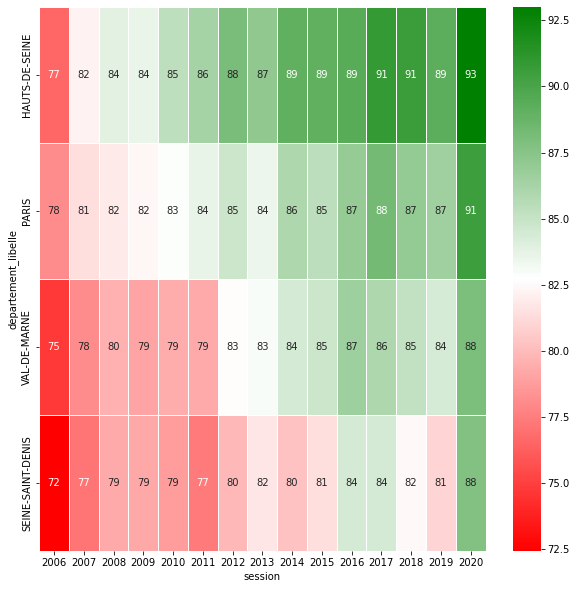

In [19]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.crosstab(df1_brevet['departement_libelle'], df1_brevet['session'], values=df1_brevet['taux_de_reussite'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

***On voit qu'il y a eu une augmentation soutenue du taux de reussite au brevet depuis 2006.
Dépassant 90% l'année 2020 dans le cas de Paris et des Hautes-de-Seine.***

### 3.1.2 Par commune

<AxesSubplot:xlabel='session', ylabel='commune_et_arrondissement_lib_l'>

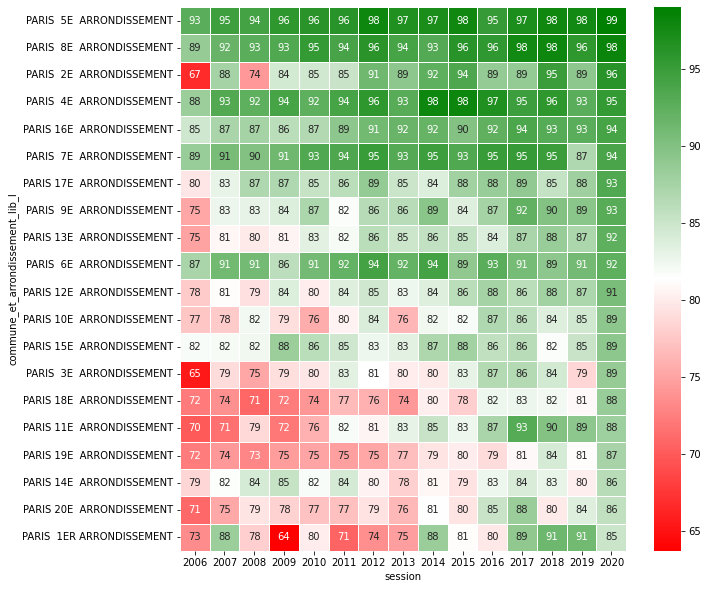

In [20]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_brevet=df1_brevet[df1_brevet['departement_libelle']=='PARIS']
sns.heatmap(pd.crosstab(df2_brevet['commune_et_arrondissement_lib_l'], df2_brevet['session'], values=df2_brevet['taux_de_reussite'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

***Si on regarde par les arrondissement à Paris on constate aussi une augmentation soutenue. Les districts avec les taux de réussite les plus élevés sont 5ème, 8ème, 4ème et 16ème. Également 2ème avec une croissance légèrement erratique. Autre remarque, la situation avec le 6ème qui a longtemps eu de très bons résultats, mais l'année dérnière il n'était pas dans le top 5.***

<AxesSubplot:xlabel='session', ylabel='commune_et_arrondissement_lib_l'>

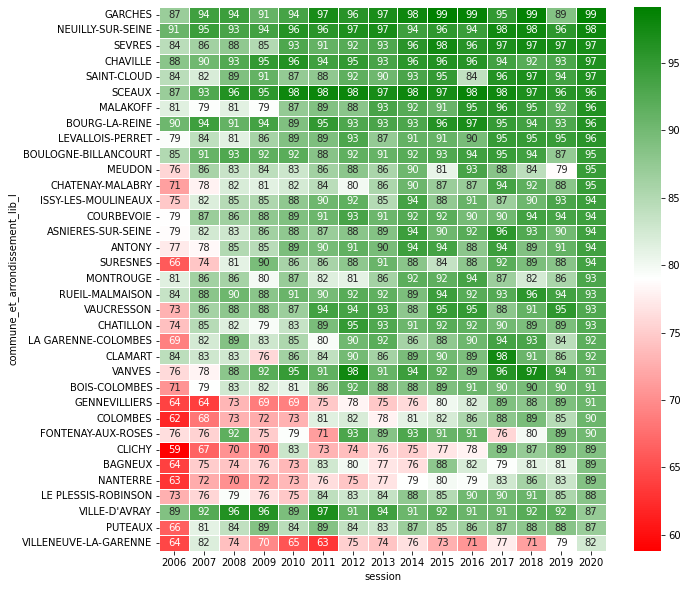

In [21]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_brevet=df1_brevet[df1_brevet['departement_libelle']=='HAUTS-DE-SEINE']
sns.heatmap(pd.crosstab(df2_brevet['commune_et_arrondissement_lib_l'], df2_brevet['session'], values=df2_brevet['taux_de_reussite'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

<AxesSubplot:xlabel='session', ylabel='commune_et_arrondissement_lib_l'>

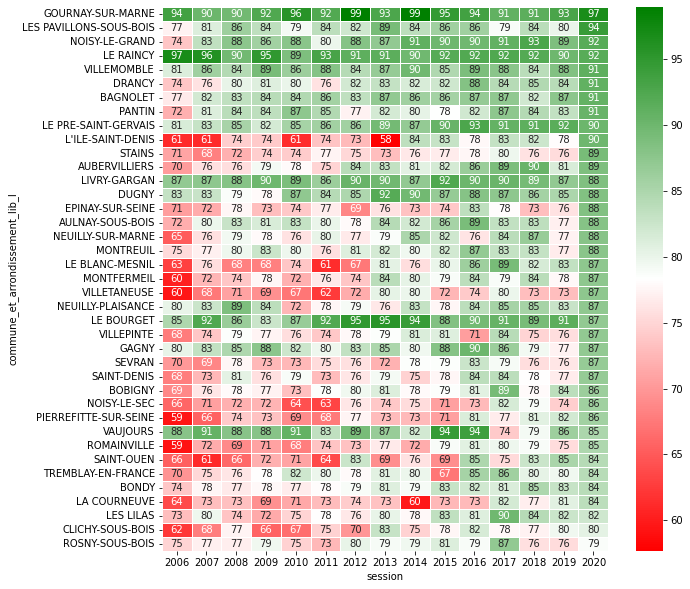

In [22]:
fig, ax = plt.subplots(figsize=(10,10)) 
df2_brevet=df1_brevet[df1_brevet['departement_libelle']=='SEINE-SAINT-DENIS']
sns.heatmap(pd.crosstab(df2_brevet['commune_et_arrondissement_lib_l'], df2_brevet['session'], values=df2_brevet['taux_de_reussite'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

<AxesSubplot:xlabel='session', ylabel='commune_et_arrondissement_lib_l'>

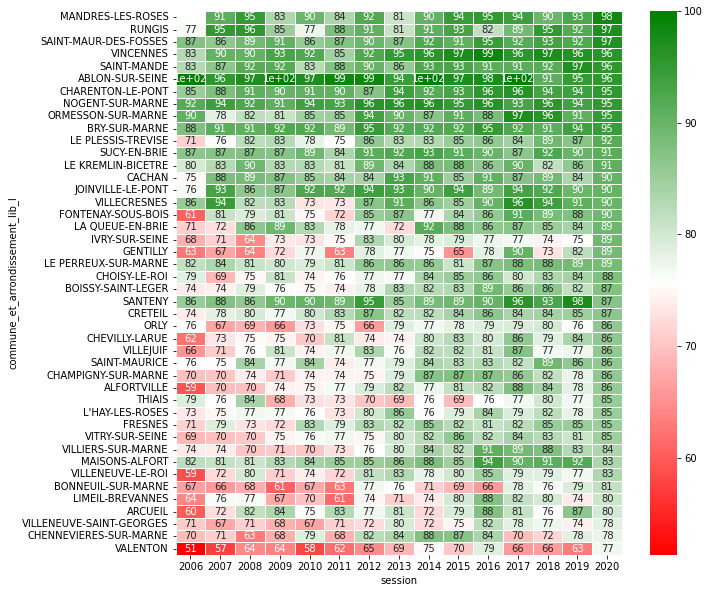

In [23]:
fig, ax = plt.subplots(figsize=(10,10)) 
df2_brevet=df1_brevet[df1_brevet['departement_libelle']=='VAL-DE-MARNE']
sns.heatmap(pd.crosstab(df2_brevet['commune_et_arrondissement_lib_l'], df2_brevet['session'], values=df2_brevet['taux_de_reussite'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

***Les cartes thermiques montrent également une disparité entre les différentes communes, mais nous avons une granularité plus marquée, nous n'avons donc pas pu avoir un résultat aussi concluant.***

### 3.1.3 Par type de institution

In [24]:
pd.concat([pd.crosstab(df1_brevet['session'],df1_brevet['secteur_d_enseignement'], normalize='index').rename(columns={'PRIVE': 'Part_PRIVE', 'PUBLIC': 'Part_Public'}),
           pd.crosstab(df1_brevet['session'],df1_brevet['secteur_d_enseignement'], values=df1_brevet['taux_de_reussite'],aggfunc=['mean','std'])], axis=1).round(2)

Part_PRIVE  Part_Public  (mean, PRIVE)  (mean, PUBLIC)  (std, PRIVE)  \
session                                                                         
2006           0.27         0.73          90.66           70.12         11.48   
2007           0.27         0.73          92.89           75.02         12.46   
2008           0.27         0.73          93.80           76.59          9.69   
2009           0.26         0.74          92.55           77.10         12.56   
2010           0.26         0.74          94.81           77.05          9.67   
2011           0.26         0.74          94.24           77.39          9.53   
2012           0.26         0.74          95.14           79.94         10.87   
2013           0.25         0.75          94.82           80.08         10.35   
2014           0.25         0.75          96.01           81.22          8.10   
2015           0.25         0.75          94.67           81.85         11.98   
2016           0.25         0.75          96.56           83.55          7.26   
2017           0.24         0.76          93.97           85.25         10.25   
2018           0.24         0.76          94.42           83.60         11.38   
2019           0.25         0.75          94.33           82.27         10.51   
2020           0.25         0.75          96.69           87.55          6.75   

         (std, PUBLIC)  
session                 
2006             11.86  
2007             11.17  
2008             10.96  
2009             10.82  
2010             10.78  
2011             10.85  
2012             10.43  
2013             10.88  
2014             11.12  
2015             10.10  
2016              9.54  
2017              9.77  
2018             10.02  
2019             10.32  
2020              7.70

In [25]:
fig = px.line(df1_brevet.groupby(['session','departement_libelle','secteur_d_enseignement'])['taux_de_reussite'].mean().reset_index(), x="session", y="taux_de_reussite", color="departement_libelle",facet_row="secteur_d_enseignement", title='Taux_de_reussite', width=1000, height=700)
fig.update_layout(legend =dict(font = dict(family = "Courier", size = 10, color = "black")),
                  legend_title = dict(font = dict(size = 20, color = "blue")))
fig.show()

***Comme on pourrait s'atteindre, la différence de taux de réussite entre les départements est plus évidente dans les institutions publiques. L'enseignement privé, en général, maintient un niveau d'éducation plus élevées, quel que soit le département où ils se trouvent.***

## 3.2 Analyse du taux de réussite au BAC (Technique et géneral)

### 3.2.1 BAC général

In [26]:
df2 = df1[['Etablissement','Annee','Ville','Academie','Taux de reussite - L','Taux de reussite - ES','Taux de reussite - S']]

In [27]:
df_bac['Annee']=pd.to_datetime(df_bac['Annee'], format= '%Y')
df_bac['Annee'] = pd.DatetimeIndex(df_bac['Annee']).year
df_bac['Academie']=df_bac['Academie'].astype(str)
df_bac['Taux de reussite - L']=df_bac['Taux de reussite - L'].replace('[\%,]', '', regex=True).astype(float)/100

In [28]:
df2_bac=df_bac[df_bac['Departement'].isin(['Hauts-de-Seine','Seine-Saint-Denis','Val-de-Marne'])]

In [29]:
df2.groupby(['Ville']).agg(avg_tx_réussite_L=('Taux de reussite - L','mean'),avg_tx_réussite_ES = ('Taux de reussite - ES', 'mean'),avg_tx_réussite_S = ('Taux de reussite - S', 'mean')).round(2)

avg_tx_réussite_L  avg_tx_réussite_ES  avg_tx_réussite_S
Ville                                                             
PARIS 03              94.35               92.79              91.83
PARIS 04              99.25               98.60              99.11
PARIS 05              99.27               99.53              99.44
PARIS 06              98.00               98.44              97.44
PARIS 07              96.50               98.35              99.62
PARIS 08              98.89               98.19              98.19
PARIS 09              90.54               89.00              82.46
PARIS 10              96.08               95.61              95.28
PARIS 11              93.38               89.41              90.10
PARIS 12              95.00               91.78              91.80
PARIS 13              93.25               93.87              93.02
PARIS 14              80.56               86.63              82.77
PARIS 15              90.72               85.81              85.78
PARIS 16              96.93               97.01              96.93
PARIS 17              98.13               97.19              96.56
PARIS 18              87.59               93.41              90.70
PARIS 19              91.87               93.81              92.32
PARIS 20              96.09               95.15              93.82

***Au bac économique et social Paris 04e, 05e, 06e le taux de réussite plus haut, Paris 14e 18e 09e le taux de réussite plus bas.
Au bac littérature Paris 05e, 04e, 06e le taux de réussite plus haut, Paris 15e 14e 09e le taux de réussite plus bas.
Au bac scientifique Paris 05e, 04e, 07e le taux de réussite plus haut, Paris 14e 15e 09e le taux de réussite plus bas.
En utilisant ce tableau, nous constatons qu'il y a peu de corrélation entre la haute performance des arrondissments et le changement dans le temps, car les arrondissements qui ont obtenu de bons résultats ont largement excellé de 2012 à 2020, et les arrondissements qui ont obtenu de moins bons résultats ont maintenu cette situation au cours des huit années.***

###  Analyse sur la petite couronne de Paris

### Nombre de participants au Bac général

In [30]:
# Heatmap pour présenter le nombre de participant du BAC général
pd.crosstab(df2_bac['Departement'], df2_bac['Annee'], values=df2_bac['total_eleves_general'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False)

Annee                2012    2013    2014    2015    2016    2017    2018  \
Departement                                                                 
Hauts-de-Seine     203.56  201.09  212.17  218.76  223.29  226.42  232.70   
Seine-Saint-Denis  157.64  159.78  160.14  169.89  181.58  193.65  211.35   
Val-de-Marne       163.74  163.29  162.31  172.40  173.43  178.14  193.42   

Annee                2019    2020  
Departement                        
Hauts-de-Seine     231.32  236.07  
Seine-Saint-Denis  206.24  207.38  
Val-de-Marne       196.69  203.66

***En général, on voit que le nombre de lycéens qui passent les BAC générales augmente d'année en année, mais le nombre de participants dans le Val-de-Marne est faible par rapport aux autres provinces.***

### Taux de réussite du Bac général

<AxesSubplot:xlabel='Annee', ylabel='Departement'>

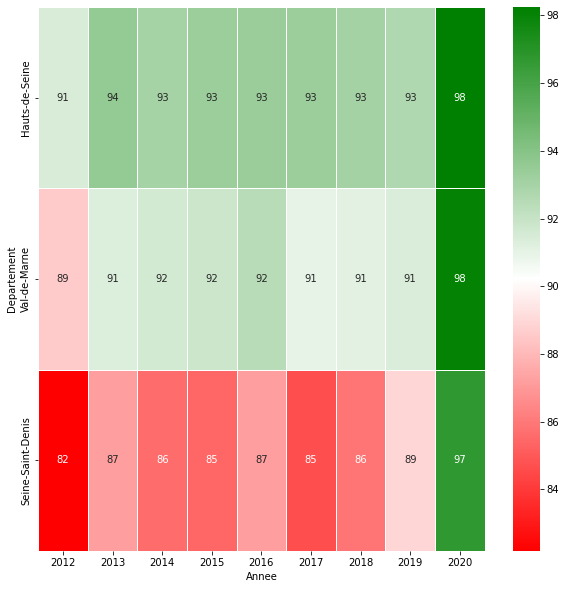

In [31]:
# Heatmap pour présenter le taux de réussite du BAC général
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.crosstab(df2_bac['Departement'], df2_bac['Annee'], values=df2_bac['Taux_reussite_general'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

***Selon ce heatmap, on voit bien que depuis 2012, le Seine-Saint-Denis a obtenu des résultats médiocres par rapport aux deux autres provinces, mais qu'elle était la province la plus performante en 2020 en termes de résultats au BAC général ; le Hauts-de-Seine a obtenu de bons résultats, suivie par le Val-de-Marne.***

### 3.2.2 BAC technique

### Nombre de section technique par département

<AxesSubplot:xlabel='Annee', ylabel='Departement'>

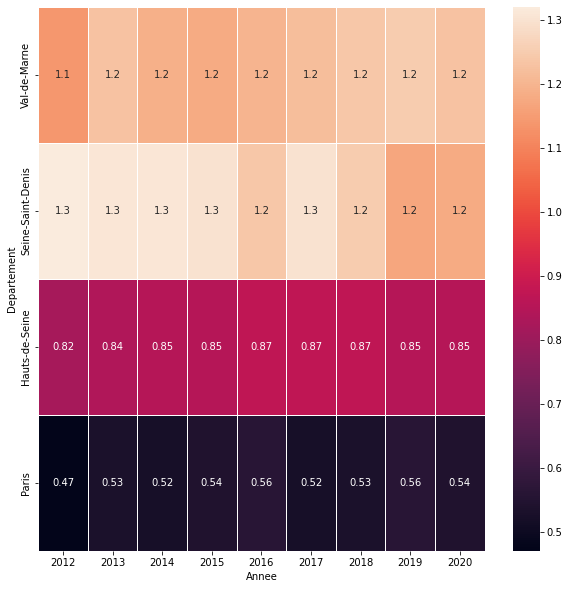

In [32]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.crosstab(df1_bac['Departement'], df1_bac['Annee'], values=df1_bac['Nombre_section_tecnique'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, linewidths=.5, ax=ax)

### Nombre de section technique par commune

#### Paris

<AxesSubplot:xlabel='Annee', ylabel='Ville'>

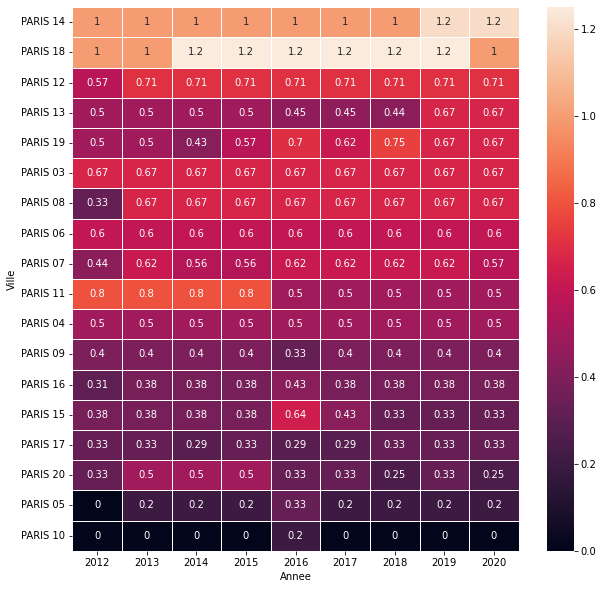

In [33]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_bac=df1_bac[df1_bac['Departement']=='Paris']
sns.heatmap(pd.crosstab(df2_bac['Ville'], df2_bac['Annee'], values=df2_bac['Nombre_section_tecnique'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, linewidths=.5, ax=ax)

#### Hauts-de-Seine

<AxesSubplot:xlabel='Annee', ylabel='Ville'>

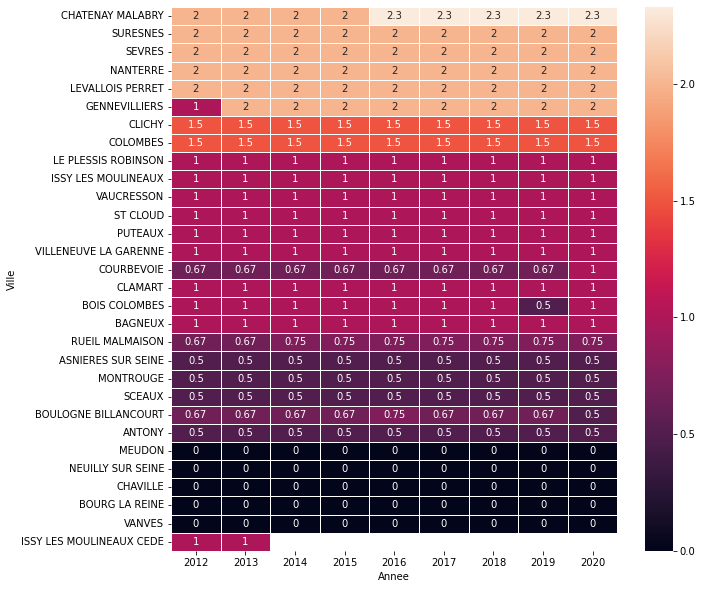

In [34]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_bac=df1_bac[df1_bac['Departement']=='Hauts-de-Seine']
sns.heatmap(pd.crosstab(df2_bac['Ville'], df2_bac['Annee'], values=df2_bac['Nombre_section_tecnique'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, linewidths=.5, ax=ax)

#### Seine-Saint-Denis

<AxesSubplot:xlabel='Annee', ylabel='Ville'>

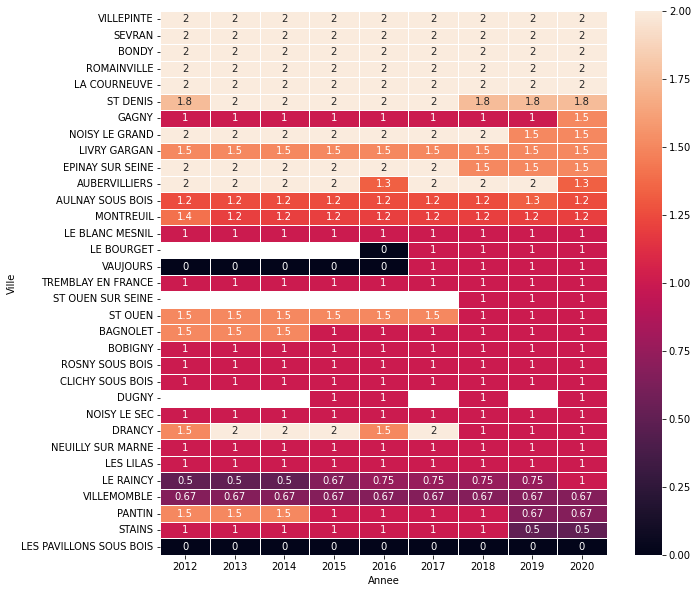

In [35]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_bac=df1_bac[df1_bac['Departement']=='Seine-Saint-Denis']
sns.heatmap(pd.crosstab(df2_bac['Ville'], df2_bac['Annee'], values=df2_bac['Nombre_section_tecnique'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, linewidths=.5, ax=ax)

#### Val-de-Marne

<AxesSubplot:xlabel='Annee', ylabel='Ville'>

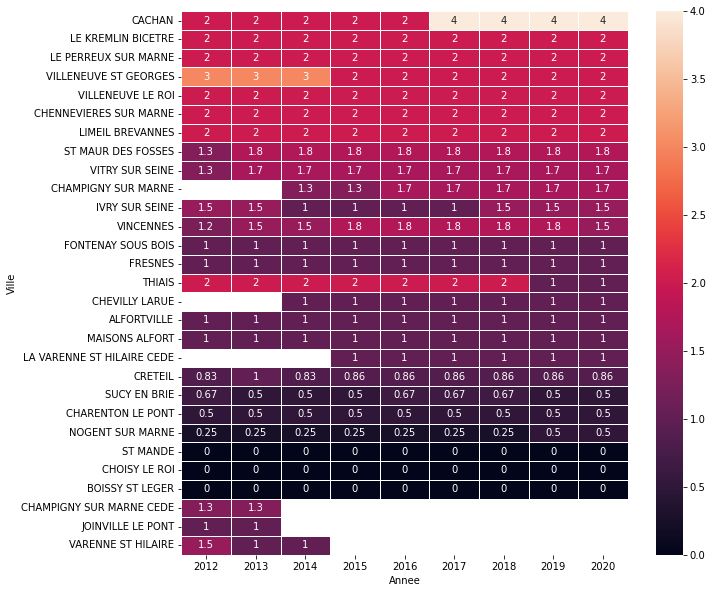

In [36]:
fig, ax = plt.subplots(figsize=(10,10))   
df2_bac=df1_bac[df1_bac['Departement']=='Val-de-Marne']
sns.heatmap(pd.crosstab(df2_bac['Ville'], df2_bac['Annee'], values=df2_bac['Nombre_section_tecnique'],aggfunc='mean').round(2).sort_values(by=[2020], ascending=False), annot=True, linewidths=.5, ax=ax)

***Par rapport au nombre de sections techniques, par département et aussi par commune, on observe qu'il existe une correspondance entre les communes défavorisées et le nombre de sections techniques. Dans la littérature, on constate que des inégalités apparaissent parfois dans les choix des étudiants par rapport à leur parcours d'études.***

### Taux de reussite par département

In [37]:
fig = px.line(df1_bac.groupby(['Annee','code_departement'])['Taux_reussite_technique'].mean().reset_index(), x="Annee", y="Taux_reussite_technique", color="code_departement", title='Taux_de_reussite - TECHNIQUE', width=950, height=560)
fig.update_layout(legend =dict(font = dict(family = "Courier", size = 10, color = "black")),
                  legend_title = dict(font = dict(size = 20, color = "blue")))
fig.show()

***Même s'il y a moins d'étudiants et moins de sections techniques, les départements les plus privilégiés ont toujours un meilleur taux de réussite dans les sections techniques. Et dans la section générale, on observe département 93 avec un taux de reussite tres faible, mais dès 2019, il a commencé à se rapprocher aux autres. En 2020, l'écart entre les différentes était très faible.***

### Taux de reussite par commune

<AxesSubplot:xlabel='Annee', ylabel='Ville'>

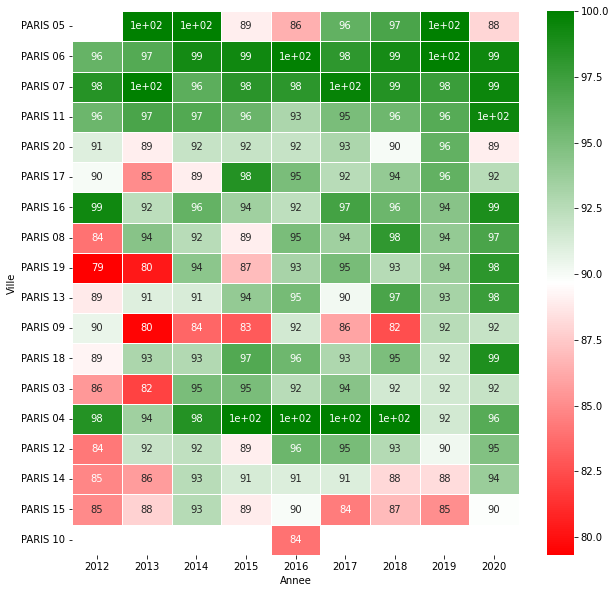

In [38]:
df2_bac=df1_bac[df1_bac['Academie']=='PARIS']
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.crosstab(df2_bac['Ville'], df2_bac['Annee'], values=df1_bac['Taux_reussite_technique'],aggfunc='mean').round(2).sort_values(by=[2019], ascending=False), annot=True, cmap=cmap, linewidths=.5, ax=ax)

***Si on regarde les taux de resussite general par les arrondissement à Paris et on fait la comparaison avec les resultats du brevet, on retrouve un comportement similaire, on constate aussi une augmentation soutenue, et les arrondissements les taux de réussite les plus élevés sont le 7ème 5ème, 4ème, 8ème, et 17ème. Il est surprenant de voir l'évolution du taux de réussite dans les 14 ème, le 18ème et le 19ème arrondissements, qui ont augmenté de 11% les deux premiers et 21% le dernier, restant au-dessus du taux de réussite de 96%. Cela peut être dû à la difficulté d'évaluation dans la situation sanitaire actuelle et peut-être les critères d'évaluation ont été assouplis.***

## 3.3 Analyse des données socio-economiques

### 3.3.1.Variation données socio-economiques entre 2013 et 2018.

In [39]:
idf= pd.read_excel('Ale/Donn/soceco2018.xlsx')

In [40]:
# Le taux de chomage 
# Tous 15-64
idf['TCHOM1564']= 100*idf['P18_CHOM1564'] / idf['P18_ACT1564']

In [41]:
# Part de cadres dans la population active
idf['TCADACTOCC1564'] = 100*idf['C18_ACTOCC1564_CS3'] / idf['C18_ACTOCC1564']

In [42]:
# Le taux d'emploi 
# Tous 15-64
idf['TEMPL1564']= 100*idf['P18_ACTOCC1564'] / idf['P18_POP1564']

In [43]:
# On vien de computer les statistiques pour les autres categories socioprofessionnelles.
# Part d'artisans, commercants et chefs d'entreprise dans la population active
idf['TACCACTOCC1564'] = 100*idf['C18_ACTOCC1564_CS2'] / idf['C18_ACTOCC1564']

In [44]:
# Part de professionnelles intermediares dans la population active occupée.
idf['TINTACTOCC1564'] = 100*idf['C18_ACTOCC1564_CS4'] / idf['C18_ACTOCC1564_CS4']

In [45]:
 # Part d'employés dans la population active occupée.
idf['TEMPLACTOCC1564'] = 100*idf['C18_ACTOCC1564_CS5'] / idf['C18_ACTOCC1564']

In [46]:
# Part d'ouvriers dans la population active occupée.
idf['TOUVRACTOCC1564'] = 100*idf['C18_ACTOCC1564_CS6'] / idf['C18_ACTOCC1564']

In [47]:
idf= idf[['CODGEO','DEP','LIBGEO','TEMPL1564','TCHOM1564','TCADACTOCC1564','TACCACTOCC1564','TINTACTOCC1564','TEMPLACTOCC1564',
         'TOUVRACTOCC1564']]
# On selectionne que les colomnes que on utiliserà 

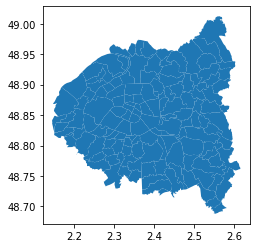

In [48]:
mapp="Ale/Donn/maps.shp"
mappe = gpd.read_file(mapp)
mappe.plot();
# Ca c'est le shape file pour la petite couronne de Paris (Dep: 75,92,93,94)

In [49]:
merged = mappe.set_index('CODGEO').join(idf.set_index('CODGEO'))
merged; # Union des données avec la mappe.

In [50]:
regions = merged.dissolve(by='DEP')
regions; # Les departements sont neccessaires pour avoir les contours.

In [51]:
merged['TLOWC1564'] = merged['TEMPLACTOCC1564'] + merged['TOUVRACTOCC1564'] 

### 3.3.2 Pour l'année 2013

In [52]:
petite13= pd.read_excel('Ale/Donn/soceco2013.xlsx')

Une fois telechargées les données pour l'année 2013 on compute les memes statistiques qu'on avait pour l'année 2018 pour ensuite faire une comparaison et voir l'evolution dans ce period de 5 ans. 

In [53]:
petite13['TCHOM1564']= 100*petite13['P13_CHOM1564'] / petite13['P13_ACT1564']

In [54]:
petite13['TCADACTOCC1564'] = 100*petite13['C13_ACTOCC1564_CS3'] / petite13['C13_ACTOCC1564']

In [55]:
petite13['TEMPL1564']= 100*petite13['P13_ACTOCC1564'] / petite13['P13_POP1564']

In [56]:
petite13['TACCACTOCC1564'] = 100*petite13['C13_ACTOCC1564_CS2'] / petite13['C13_ACTOCC1564']

In [57]:
petite13['TINTACTOCC1564'] = 100*petite13['C13_ACTOCC1564_CS4'] / petite13['C13_ACTOCC1564']

In [58]:
petite13['TEMPLACTOCC1564'] = 100*petite13['C13_ACTOCC1564_CS5'] / petite13['C13_ACTOCC1564']

In [59]:
petite13['TOUVRACTOCC1564'] = 100*petite13['C13_ACTOCC1564_CS6'] / petite13['C13_ACTOCC1564']

In [60]:
petite13= petite13[['CODGEO','DEP','LIBGEO','TEMPL1564','TCHOM1564','TCADACTOCC1564','TACCACTOCC1564','TINTACTOCC1564','TEMPLACTOCC1564',
         'TOUVRACTOCC1564']]

In [61]:
diff = pd.merge(merged, petite13, on="CODGEO", suffixes=["", "_13"])
# On fait le merge des données pour les deux années avec le suffixe _13 pour distinguer les données relatives à l'année 2013.

### 3.3.3 Les differences.

In [62]:
diff['DCHOM1564']= diff['TCHOM1564'] - diff['TCHOM1564_13']

In [63]:
diff['DCHOM1564'].mean()

-0.13425450391827104

In [64]:
diff['DEMPL1564']= diff['TEMPL1564'] - diff['TEMPL1564_13']

In [65]:
diff['DCADACTOCC1564']= diff['TCADACTOCC1564'] - diff['TCADACTOCC1564_13']

In [66]:
diff['TLOWC1564_13'] = diff['TEMPLACTOCC1564_13'] + diff['TOUVRACTOCC1564_13'] 
diff['DLOWC1564']= diff['TLOWC1564'] - diff['TLOWC1564_13']

### 3.3.4 Les cartes.
#### Le chomage.

In [67]:
print(diff['DCHOM1564'].min() ,diff['DCHOM1564'].max())

-4.3076607418803725 3.8723161646246744


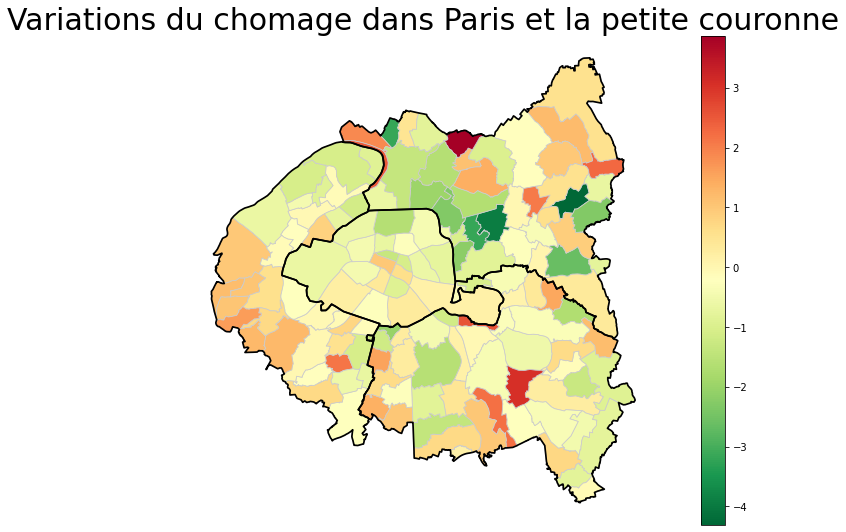

<Figure size 1152x648 with 0 Axes>

In [68]:
variable = 'DCHOM1564'
vmin, vmax = -4.307660741880383, 3.8723161646246744
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.figure(figsize=(16,9))
diff.plot(column=variable, cmap='RdYlGn_r', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Variations du chomage dans Paris et la petite couronne", fontsize=30)
plt.show();
# En général le taux de chomage a baissé un peu partout avec quelques exceptions à nord-est et sud-ouest e la petite couronne.

#### Pour le variations du taux d'emploi

In [69]:
print(diff['DEMPL1564'].min() ,diff['DEMPL1564'].max())

-5.384820734847764 3.832114628265302


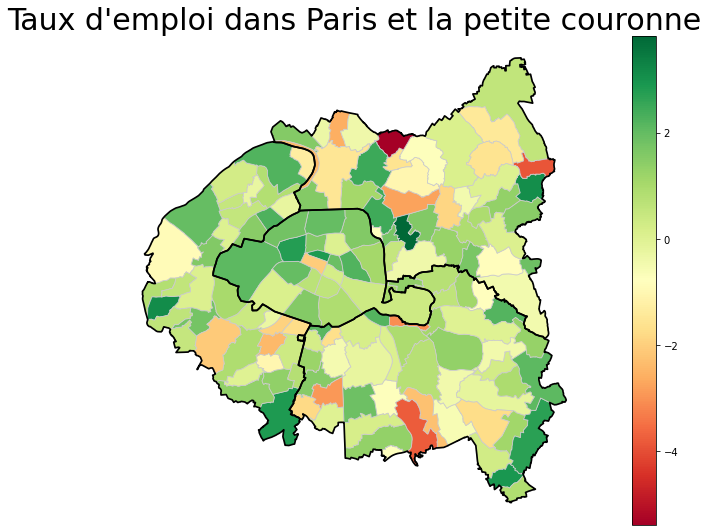

<Figure size 1152x648 with 0 Axes>

In [70]:
variable = 'DEMPL1564'
vmin, vmax = -5.384820734847764, 3.832114628265302
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.figure(figsize=(16,9))
diff.plot(column=variable, cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Taux d'emploi dans Paris et la petite couronne", fontsize=30)
plt.show();
# Le vert dans ce cas est plus diffuse, donc on peut dire que en général le taux d'emploi a augmenté presque partout. 

#### Pour le taux de cadres. 

In [71]:
print(diff['DCADACTOCC1564'].min() ,diff['DCADACTOCC1564'].max())

-7.286329872764281 7.879031168948803


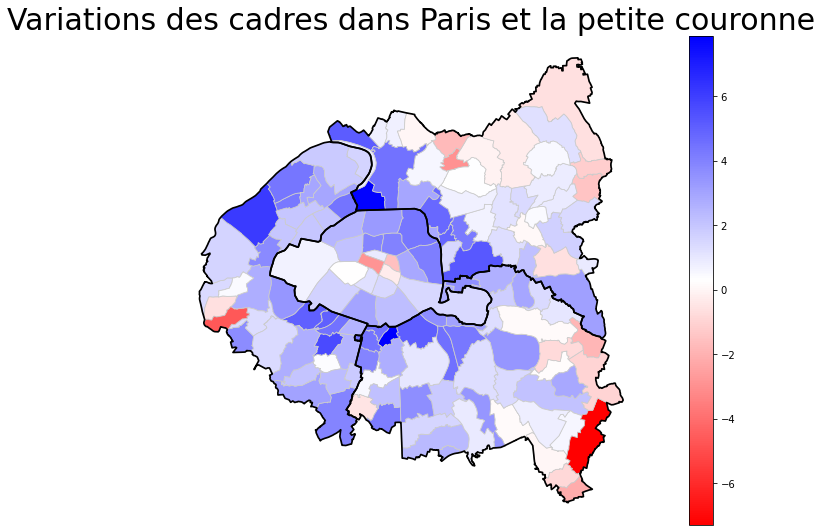

<Figure size 1152x648 with 0 Axes>

In [72]:
variable = 'DCADACTOCC1564'
vmin, vmax = -7.28632987276427, 7.879031168948803
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='bwr_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.figure(figsize=(16,9))
diff.plot(column=variable, cmap='bwr_r', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Variations des cadres dans Paris et la petite couronne", fontsize=30)
plt.show();

***Les cadres sont augmentées presque partout, il peut y avoir plusieurs explications, une explication peut etre liée au fait que les ouvriers et eployeées ont quittés la petite couronne pour la grande couronne ou peut etre que il y a plus de postes comme cadre dans la petite couronne en 2018 que avant en 2013.***

#### Pour les ouvriers et employés


In [73]:
print(diff['DLOWC1564'].min() ,diff['DLOWC1564'].max())

-8.099657496229128 7.003354567955029


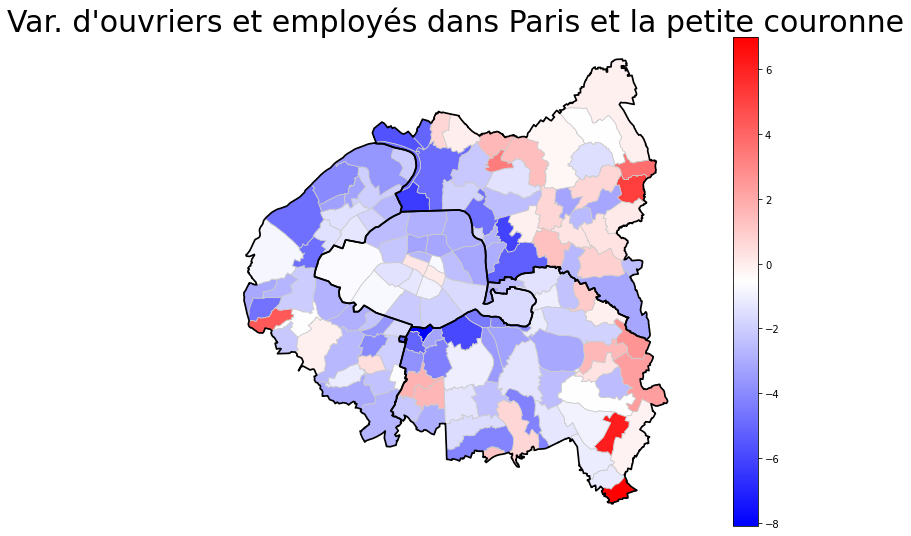

<Figure size 1152x648 with 0 Axes>

In [74]:
variable = 'DLOWC1564'
vmin, vmax = -8.099657496229142, 7.003354567955018
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.figure(figsize=(16,9))
diff.plot(column=variable, cmap='bwr', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Var. d'ouvriers et employés dans Paris et la petite couronne", fontsize=30)
plt.show();

***Dans ce cas le graphique est l'opposé du graphique pour les cadres.***

# 4. CONCLUSION

Finalement, nous avons rassemblé toutes les données, tant académiques que socioprofessionnelles, afin de conclure.

In [75]:
df3_brevet=df1_brevet[df1_brevet['session'].isin([2013, 2018])]
df4_brevet=pd.DataFrame(df3_brevet.groupby(by=['session','departement', 'departement_libelle','commune_et_arrondissement', 'commune_et_arrondissement_lib_l'  ], dropna=False).mean().reset_index().round(2))

In [76]:
df3_bac=df1_bac[df1_bac['Annee'].isin([2013, 2018])]
df4_bac=pd.DataFrame(df3_bac.groupby(by=['Annee', 'Code commune','Code region' ], dropna=False).mean().reset_index().round(2))
df4_bac=df4_bac[['Annee', 'Code commune', 'Code region', 'Taux_mentions_technique','Taux_mentions_general', 'total_eleves_technique', 'Nombre_section_tecnique',
       'Taux_reussite_general', 'Taux_reussite_technique', ]]

In [77]:
CSP_18=merged
CSP_18['CODGEO']=CSP_18.index
CSP_18['Annee']=2018
CSP_13=petite13
CSP_13['Annee']=2013
CSP=CSP_18.append(CSP_13).reset_index()
CSP=CSP[['CODGEO','Annee','DEP', 'LIBGEO','TEMPL1564', 'TCHOM1564', 'TCADACTOCC1564', 'TACCACTOCC1564','TINTACTOCC1564', 'TEMPLACTOCC1564', 'TOUVRACTOCC1564', 'TLOWC1564']]

In [78]:
df_group= pd.merge(df4_brevet.add_prefix('Brev_'), df4_bac.add_prefix('BAC_'), how='outer', left_on=['Brev_session', 'Brev_commune_et_arrondissement'], right_on=['BAC_Annee', 'BAC_Code commune']).drop(['BAC_Annee', 'BAC_Code commune', 'BAC_Code region'], axis=1)

In [79]:
df_group['Brev_commune_et_arrondissement']=df_group['Brev_commune_et_arrondissement'].astype(int)
df_group= pd.merge(df_group, CSP, how='outer', left_on=['Brev_session', 'Brev_commune_et_arrondissement'], right_on=['Annee', 'CODGEO'])
df_group=df_group[['CODGEO', 'Annee', 'DEP', 'LIBGEO','Brev_nombre_d_inscrits',
       'Brev_nombre_de_presents', 'Brev_nombre_total_d_admis',
       'Brev_nombre_d_admis_sans_mention', 'Brev_nombre_d_admis_mention_ab',
       'Brev_nombre_d_admis_mention_b', 'Brev_nombre_d_admis_mention_tb',
       'Brev_taux_de_reussite', 'BAC_Taux_mentions_technique',
       'BAC_Taux_mentions_general', 'BAC_total_eleves_technique',
       'BAC_Nombre_section_tecnique', 'BAC_Taux_reussite_general',
       'BAC_Taux_reussite_technique',
       'TEMPL1564', 'TCHOM1564', 'TCADACTOCC1564', 'TACCACTOCC1564',
       'TINTACTOCC1564', 'TEMPLACTOCC1564', 'TOUVRACTOCC1564', 'TLOWC1564']]

In [81]:
df_group_1=df_group[['DEP','Brev_nombre_d_inscrits',
       'Brev_nombre_de_presents', 'Brev_nombre_total_d_admis',
       'Brev_nombre_d_admis_sans_mention', 'Brev_nombre_d_admis_mention_ab',
       'Brev_nombre_d_admis_mention_b', 'Brev_nombre_d_admis_mention_tb',
       'Brev_taux_de_reussite', 'BAC_Taux_mentions_technique',
       'BAC_Taux_mentions_general', 'BAC_total_eleves_technique',
       'BAC_Nombre_section_tecnique', 'BAC_Taux_reussite_general',
       'BAC_Taux_reussite_technique',
       'TEMPL1564', 'TCHOM1564', 'TCADACTOCC1564', 'TACCACTOCC1564',
       'TINTACTOCC1564', 'TEMPLACTOCC1564', 'TOUVRACTOCC1564', 'TLOWC1564']]

In [82]:
df_group_1 = pd.get_dummies(df_group_1, columns=['DEP'], drop_first=False)

In [96]:
df3=df_group_1[['DEP_75', 'DEP_92', 'DEP_93', 'DEP_94',
       'Brev_nombre_d_admis_sans_mention', 'Brev_nombre_d_admis_mention_ab',
       'Brev_nombre_d_admis_mention_b', 'Brev_nombre_d_admis_mention_tb',
       'Brev_taux_de_reussite', 'BAC_Taux_mentions_technique',
       'BAC_Taux_mentions_general', 'BAC_Nombre_section_tecnique', 'BAC_Taux_reussite_general',
       'BAC_Taux_reussite_technique',
       'TCHOM1564', 'TCADACTOCC1564', 'TACCACTOCC1564',
       'TINTACTOCC1564', 'TLOWC1564']]
df3 = df3.rename(columns={'TCHOM1564':'Taux_chomage', 'TCADACTOCC1564':'Taux_cadres', 'TACCACTOCC1564':'Taux_art_com_dir',
       'TINTACTOCC1564':'Taux_prof_int', 'TLOWC1564':'Taux_class_inf'})

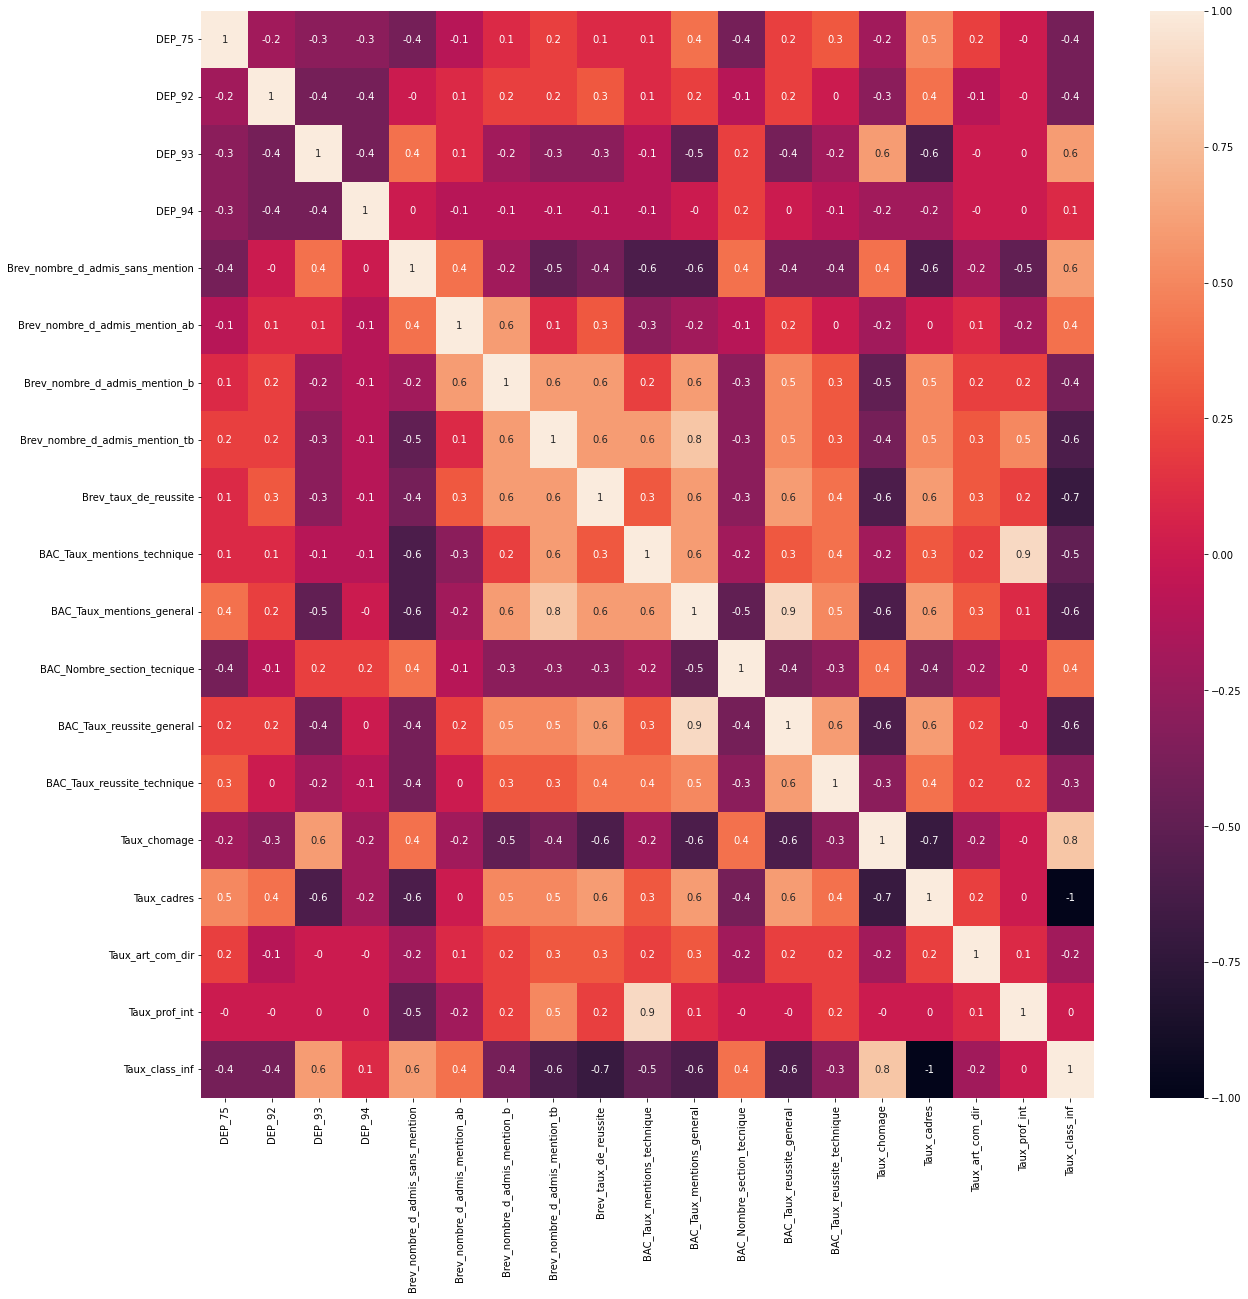

In [97]:
plt.rcParams["figure.figsize"] = (20,20)
sns.heatmap(df3.corr(). round(1), annot=True);

***Ce correlogramme nous donne une idée sur la correlation entre les caractéristiques socio-économiques du territoire et les performances scolaires, nous pouvons conclure le suivant:***

***1. Il y a une correlation negative entre le taux de chomage et le taux de reussite au brevet et BAC. Par contre, nous pouvons observer qu'il ya une correlation positive entre le taux de cadres et le taux de reussite au brevet et BAC.***

***2. Nous pouvons voir que le taux de cadres, taux de artisans, commerçants et directeurs, et le taux de professionnelles intermediares sont negativement correlé au taux de admis sans mention au brevet, et positivement correlé aux taux de admis mention bien et très bien et aussi au taux de mention au BAC. On observe le comportement inverse pour le taux de classe inférieure (ouvriers et employés).*** 

***3. Le département Seine-Saint-Denis a une correlation négative avec le taux de mentions au BAC et positive avec le taux d'admis sans mention au brevet. On observe un correlation inverse à Paris.***

***4. Le taux de chomage a un correlation plus haut dans le département de Seine-Saint-Denis et une correlation plus bas négative avec les mentions bien et très bien du Brevet, et le taux de mention au BAC et avec les taux de reussite.***

***5. Il y a une correlation négative entre le nombre des sections technique et le département de Paris***


In [92]:
merged2 = mappe.set_index('CODGEO').join(df_group[df_group['Annee']==2018].set_index('CODGEO'))
communes = merged2.dissolve(by='CODGEO')
communes['centroid'] = communes['geometry'].centroid

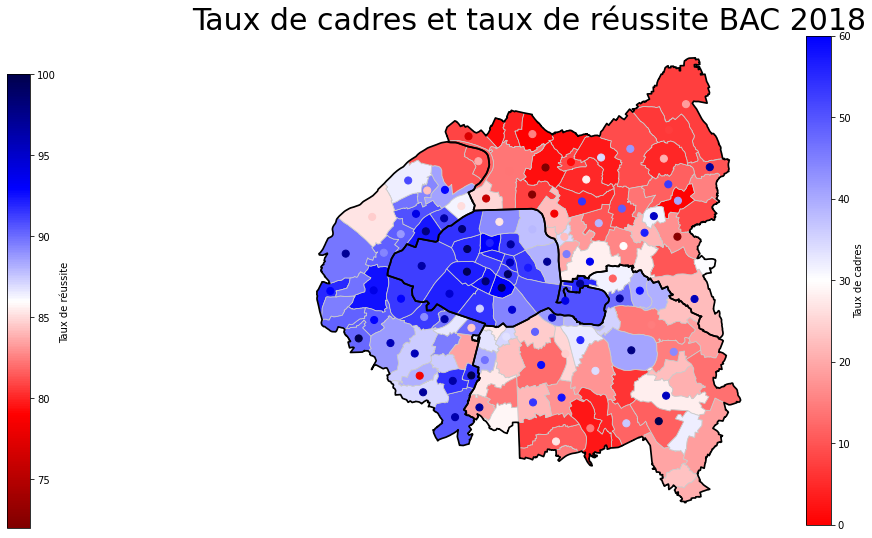

<Figure size 1152x648 with 0 Axes>

In [93]:
variable = 'TCADACTOCC1564'
variable2 = 'BAC_Taux_reussite_general'
vmin, vmax = 0, 60
vmin2,vmax2 = 72, 100
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='bwr_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm2 = plt.cm.ScalarMappable(cmap='seismic_r', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
# empty array for the data range
sm._A = []
sm2._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label='Taux de cadres')
cbaxes = fig.add_axes([0.09, 0.12, 0.02, 0.7])
cbar2 = fig.colorbar(sm2, cax=cbaxes, label='Taux de réussite')
plt.figure(figsize=(16,9))
merged2.plot(column=variable, cmap='bwr_r', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Taux de cadres et taux de réussite BAC 2018", fontsize=30)
ax.scatter(communes['centroid'].x,
            communes['centroid'].y,
            marker='o', c=communes[variable2], cmap='seismic_r', alpha=1, s=50) # 'summer'
plt.show();

Points: Taux de réussite au Brevet.

Fond: Taux de cadres.

***Ce graphique montre comme le taux de cadres dans l'arrondissement/commune et le taux de réussite au BAC sont liés. Comme montrée par la carte pointue dans les communes/arrondissements où il y à plus de cadres, le taux de réussite au BAC est plus élevé.
Cette relation semble plus marquée en Hauts-de-France où les communes comme Colombes et Nanterre qui ont moins de cadres (en %) 
que les autres communes du département sont aussi ceux où le taux de réussite est plus faible.***




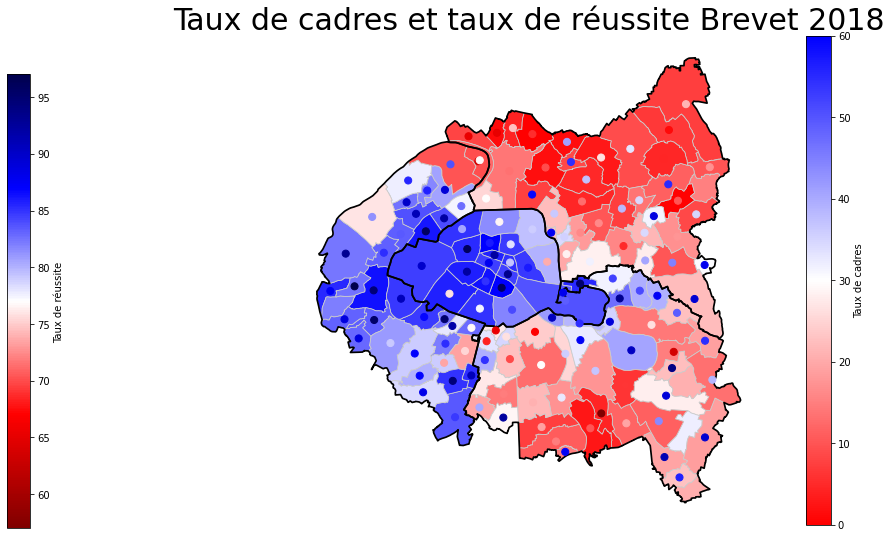

<Figure size 1152x648 with 0 Axes>

In [95]:
variable = 'TCADACTOCC1564'
variable2 = 'Brev_taux_de_reussite'
vmin, vmax = 0, 60
vmin2,vmax2 = 57, 97
# Create colorbar as a legend
fig, ax = plt.subplots(1, figsize=(16, 9))
sm = plt.cm.ScalarMappable(cmap='bwr_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm2 = plt.cm.ScalarMappable(cmap='seismic_r', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
# empty array for the data range
sm._A = []
sm2._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label='Taux de cadres')
cbaxes = fig.add_axes([0.09, 0.12, 0.02, 0.7])
cbar2 = fig.colorbar(sm2, cax=cbaxes, label='Taux de réussite')
plt.figure(figsize=(16,9))
merged2.plot(column=variable, cmap='bwr_r', linewidth=0.8, ax=ax, edgecolor='0.8')
regions.plot(color='None', edgecolor='black', linewidth=1.7, ax=ax)
ax.axis('off')
ax.set_title("Taux de cadres et taux de réussite Brevet 2018", fontsize=30)
ax.scatter(communes['centroid'].x,
            communes['centroid'].y,
            marker='o', c=communes[variable2], cmap='seismic_r', alpha=1, s=50) # 'summer'
plt.show();

Points: Taux de réussite au Brevet.

Fond: Taux de cadres.

***La relation entre les catégories socioprofessionnelles et les performances scolaires semble moins claire si l'on considère le brevet,
surtout en regardant certaines municipalités dans le département de Seine-Saint-Denis.
Cela peut dépendre du fait que il est plus facile de passer le brevet.***